In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


In [2]:

# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-04-02 09:31:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-02 09:31:22 (82.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
From (redirected): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk&confirm=t&uuid=3eb46405-4d9e-47d5-b490-7add42c5a4a3
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:09<00:00, 87.9MB/s]


In [4]:
import os

filenames = os.listdir("./train")

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'class': categories
})
df.head()

,filename,class
0,cat.3824.jpg,0
1,dog.3465.jpg,1
2,dog.10703.jpg,1
3,dog.3263.jpg,1
4,dog.1993.jpg,1


In [5]:
df["class"] = df["class"].replace({0: 'cat', 1: 'dog'})
df.head()

,filename,class
0,cat.3824.jpg,cat
1,dog.3465.jpg,dog
2,dog.10703.jpg,dog
3,dog.3263.jpg,dog
4,dog.1993.jpg,dog


In [6]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=7)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [7]:
train_df

,filename,class
0,cat.1668.jpg,cat
1,cat.6189.jpg,cat
2,dog.325.jpg,dog
3,dog.10429.jpg,dog
4,cat.3757.jpg,cat
...,...,...
19995,cat.5851.jpg,cat
19996,cat.9414.jpg,cat
19997,cat.9077.jpg,cat
19998,dog.10215.jpg,dog


In [8]:
# Define our images sizes
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [9]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train/",
    x_col = 'filename',
    y_col = 'class',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./train/",
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [13]:
class_indices = train_generator.class_indices
class_label_names = list(class_indices.keys())
print("Class label names:", class_label_names)

Class label names: ['cat', 'dog']


In [30]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.VGG16(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dropout(0.3)(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(2, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              metrics=["accuracy"])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# 10. Fit the model (we use less steps for validation so it's faster)
history = model_0.fit(train_generator,
                                 epochs=25,
                                 steps_per_epoch=len(train_generator),
                                 validation_data=validation_generator,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(validation_generator)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "model"),
                                            early_stopping])

Shape after base_model: (None, 7, 7, 512)
After GlobalAveragePooling2D(): (None, 512)
Saving TensorBoard log files to: transfer_learning/model/20240402-105313
Epoch 1/25
625/625 [==============================] - 89s 140ms/step - loss: 0.5246 - accuracy: 0.7825 - val_loss: 0.4267 - val_accuracy: 0.8534
Epoch 2/25
625/625 [==============================] - 87s 139ms/step - loss: 0.3892 - accuracy: 0.8528 - val_loss: 0.3337 - val_accuracy: 0.8910
Epoch 3/25
625/625 [==============================] - 87s 139ms/step - loss: 0.3422 - accuracy: 0.8678 - val_loss: 0.2983 - val_accuracy: 0.9038
Epoch 4/25
625/625 [==============================] - 86s 138ms/step - loss: 0.3201 - accuracy: 0.8717 - val_loss: 0.2889 - val_accuracy: 0.8910
Epoch 5/25
625/625 [==============================] - 87s 139ms/step - loss: 0.3008 - accuracy: 0.8801 - val_loss: 0.2846 - val_accuracy: 0.8926
Epoch 6/25
625/625 [==============================] - 87s 139ms/step - loss: 0.2897 - accuracy: 0.8863 - val_loss: 0

In [33]:

import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

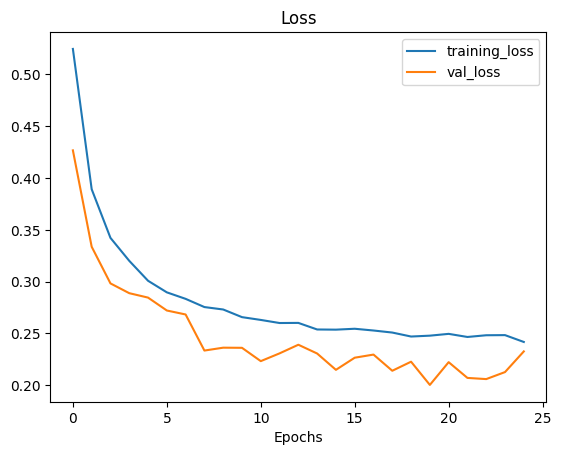

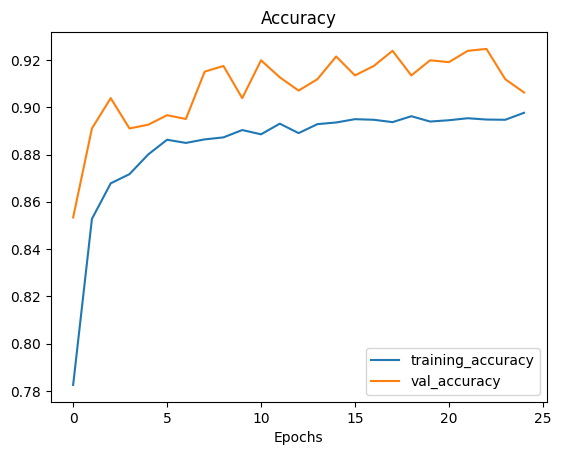

In [34]:
plot_loss_curves(history)


157/157 [==============================] - 20s 126ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.53      0.52      2491
           1       0.51      0.48      0.49      2509

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.51      0.51      0.51      5000

Confusion Matrix:
 [[1325 1166]
 [1302 1207]]
Precision: [0.50437762 0.50863885]
Recall: [0.53191489 0.48106815]
F1 Score: [0.51778038 0.49446948]


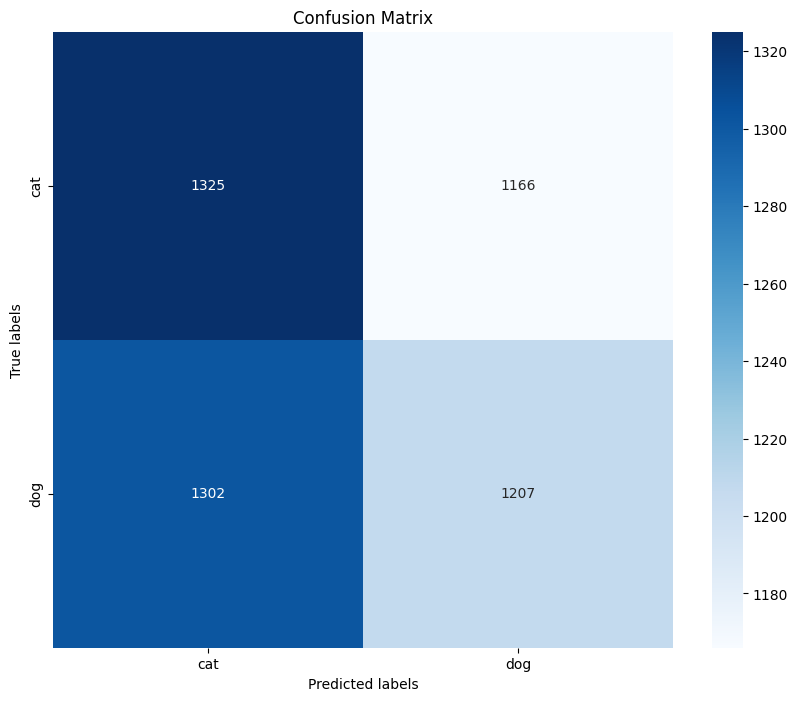

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions for the validation set
validation_generator.reset()  # Reset generator to the beginning
y_pred_prob = model_0.predict(validation_generator, steps=len(validation_generator), verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded labels to integers
y_true = validation_generator.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, and F1 score from confusion matrix
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
